### Take one transect (CTD/LADCP, SADCP), and show all the data and analysis used so far


In [1]:
#from mpl_toolkits.basemap import Basemap
import numpy as np
import scipy as sp
import scipy.stats as ss
import matplotlib.pyplot as plt
%matplotlib inline  
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)
import urllib.request
import xarray as xr
import pandas as pd
import glob
import os
#from datetime import datetime
import datetime as dt
from collections import OrderedDict
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from oceans.datasets import etopo_subset
from oceans.sw_extras import gamma_GP_from_SP_pt
from matplotlib.patches import Polygon
import gsw
from matplotlib import animation, rc
from IPython.display import HTML
import scipy.io
#import pixiedust # for pixie_debugger
import pycwt as wavelet
from pyspec import helmholtz as helm
from pyspec import spectrum as spec    
from itertools import islice # for slice OrderedDict

os.chdir("/Users/North/Drive/Work/UniH_Work/DataAnalysis/jlab_files") # need to set working directory to get the next step to work
from Benguela.src.met132_ctd_ladcp_functions import load_combine_ladcp_ctd_data #import load_ctd_data
from Benguela.src.met132_scanfish_sadcp_functions import load_combine_sadcp_scanfish_data #import load_ctd_data
import Benguela.src.met132_calc_functions as cf
import Benguela.src.met132_plotting_functions as fg
import Benguela.src.met132_sea_level_functions as sl
import Denmark_Strait.src.spectra_and_wavelet_functions as sw
import Denmark_Strait.src.ssa_core as ssa

# some colors (prettier than default boring colors)
color2 = '#6495ed'
color1 = '#ff6347'
color5 = '#8470ff'
color3 = '#3cb371'
color4 = '#ffd700'
color6 = '#ba55d3'

============================================================================================================================

#### Load the data

In [2]:
# ====== load SADCP and Scanfish data
sadcp_nc_dir = '/Users/North/Drive/Work/UniH_Work/DataAnalysis/jlab_files/Benguela/netcdf_files/'

scan_sadcp_transects_1km = OrderedDict() # Preallocate output dictionary
# actually just sadcp data, but putting them in same Dict
scan_sadcp_transects_1km['LADCP_CTD_Transect1'] = xr.open_dataset((sadcp_nc_dir+'sadcp_transects_1km_LADCP_CTD_Transect1.nc')) 
scan_sadcp_transects_1km['LADCP_CTD_Transect1'] = scan_sadcp_transects_1km['LADCP_CTD_Transect1'].set_index(xy=['x_m','x_km','lat','lon','time','time_secs'])

ctd_ladcp_transects_1km = OrderedDict() # Preallocate output dictionary
ctd_ladcp_transects_1km['LADCP_CTD_Transect1'] = xr.open_dataset((sadcp_nc_dir+'ctd_ladcp_transects_LADCP_CTD_Transect1.nc')) 
ctd_ladcp_transects_1km['LADCP_CTD_Transect1'] = ctd_ladcp_transects_1km['LADCP_CTD_Transect1'].set_index(xy=['x_m','x_km','lat','lon','time','station'])

filenames = "/Volumes/Backup/finished_work/Meteor_MET132_ADCP_Processing/ADCPprocessing/rawdata/MET_132/Analysis/maps_images/A2016324.L3m_DAY_SST_sst_4km.nc"
sst_map_19 = xr.open_dataset(filenames) # lat,lon,sst
#bwidth, bheight = 95000,115000
#sst_range=np.arange(16.5,18.51,0.25) 
#sst_map_19

============================================================================================================================

#### Some Processing

##### Horizontal kinetic energy spectra

In [3]:
for key in scan_sadcp_transects_1km:
    scan_sadcp_transects_1km[key] = cf.calc_KE(scan_sadcp_transects_1km[key])    

/Users/North/anaconda/envs/work3/lib/python3.6/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


============================================================================================================================

#### Plotting for one transect

["/bin/bash: line 0: break: only meaningful in a `for', `while', or `until' loop"]

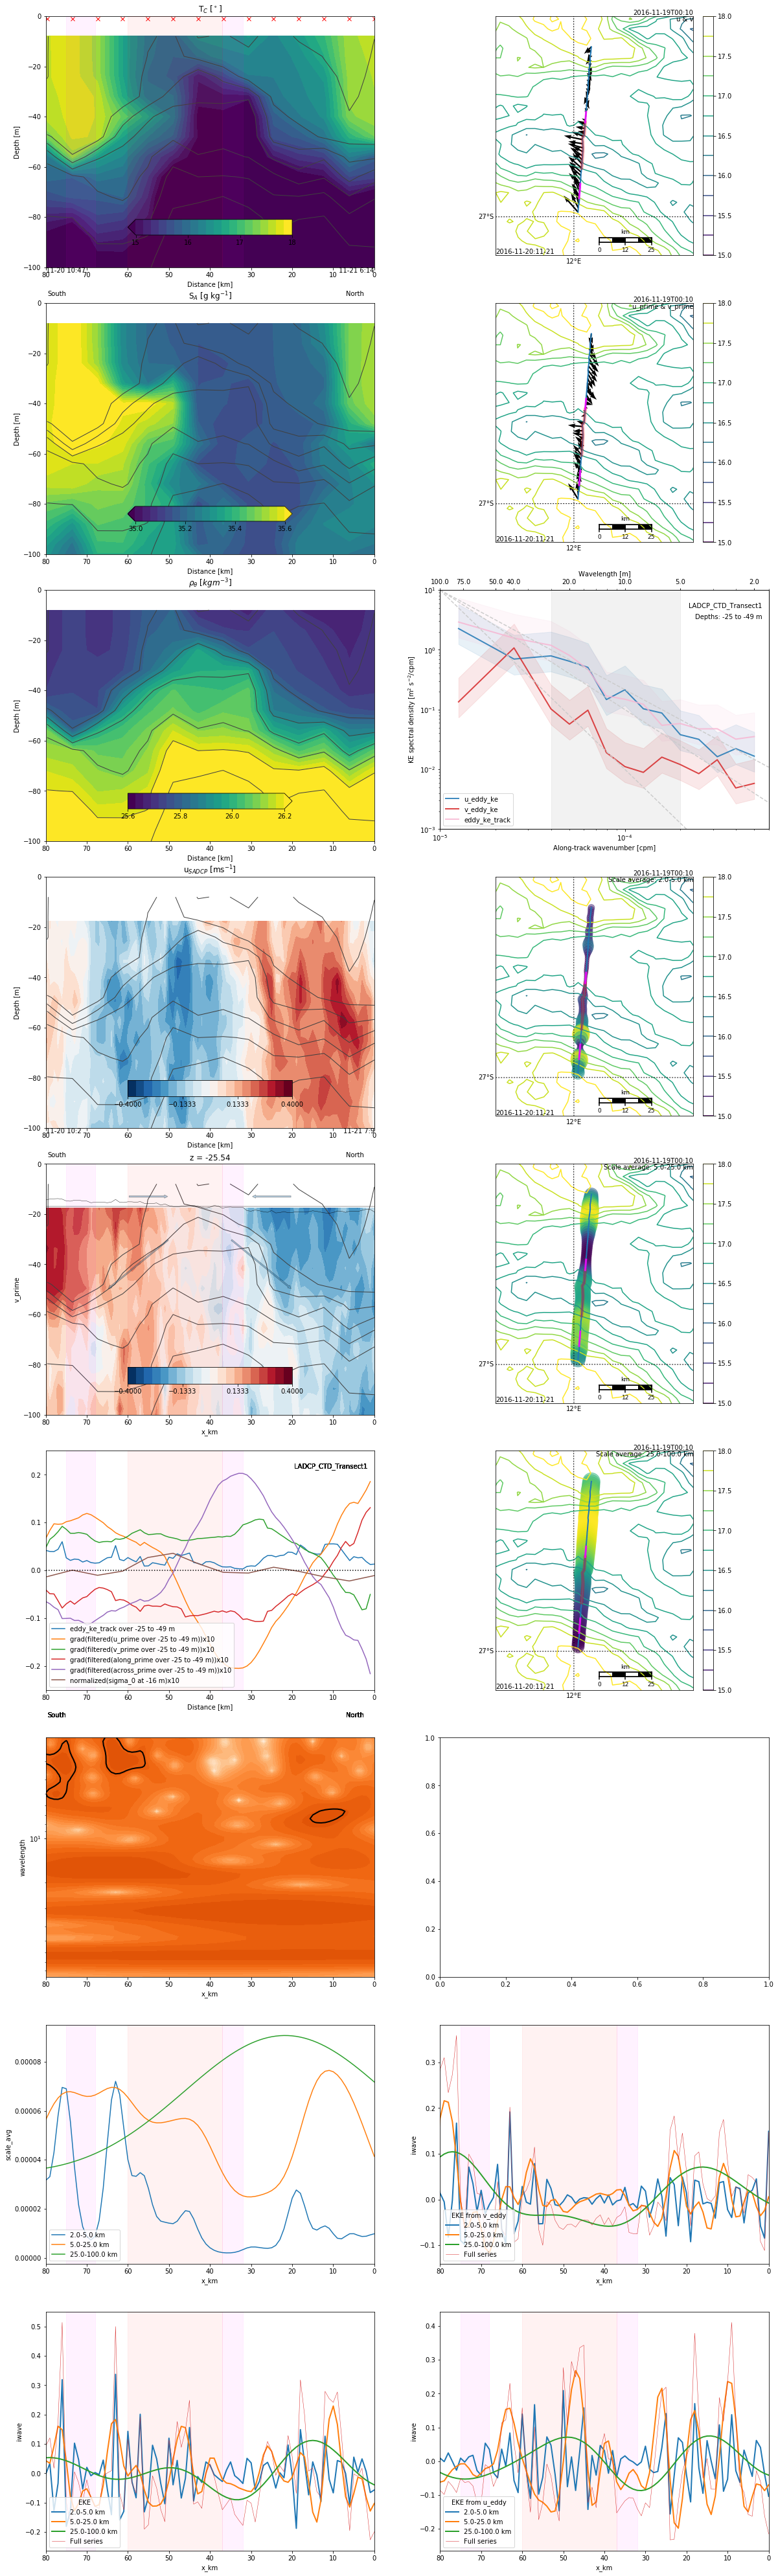

In [37]:
transect_name = 'LADCP_CTD_Transect1'
depth_range= slice(-19,-50)
nbins_spec_av=10 # i.e. binned such that nbins_spec_av points are plotted for each order of magnitude (decade)
spec_variables = list(('u_eddy_ke','v_eddy_ke','eddy_ke_track'))#,'ke_b'))

# where do the spectral slopes change?
k_slope_change = np.array((1e-5,4e-5, 2e-4,5e-4))
l_slope_change = 1e-3/k_slope_change[-1::-1]

# where are the fronts?
cold_core = np.array((37,60)) # km
north_front = np.array((32,37)) 
south_front = np.array((68,75)) 

nrows, ncols =  9,2
fig, axs = plt.subplots(nrows=nrows,ncols=ncols,figsize = (ncols*10.,nrows*8))
axs = axs.ravel()

# plan view of track, SST, and u,v sadcp vectors
si = 1
bwidth, bheight = 95000,115000
#sst_range=np.arange(16.5,18.51,0.25) 
sst_range=np.arange(15,18.25,0.25) # to match fg.plot_profile_view
m_first = fg.quick_map(scan_sadcp_transects_1km[transect_name],'u','v',sst_map_19,12.1,-26.65, bwidth, bheight,z_ind=-25,ax_in=axs[si],sst_range=sst_range)
m_first.drawmapscale(12.25, -27.1, 12.75, -27.1, 25, barstyle='fancy')
m_first.plot(scan_sadcp_transects_1km[transect_name].lon.reset_index('xy').swap_dims({'xy': 'x_km'}).sel(x_km=slice(cold_core[0],cold_core[1])).values,
              scan_sadcp_transects_1km[transect_name].lat.reset_index('xy').swap_dims({'xy': 'x_km'}).sel(x_km=slice(cold_core[0],cold_core[1])).values, alpha=0.35, color='r',linewidth=5,latlon=True)
m_first.plot(scan_sadcp_transects_1km[transect_name].lon.reset_index('xy').swap_dims({'xy': 'x_km'}).sel(x_km=slice(south_front[0],south_front[1])).values,
              scan_sadcp_transects_1km[transect_name].lat.reset_index('xy').swap_dims({'xy': 'x_km'}).sel(x_km=slice(south_front[0],south_front[1])).values, alpha=0.85, color='magenta',linewidth=3,latlon=True)
m_first.plot(scan_sadcp_transects_1km[transect_name].lon.reset_index('xy').swap_dims({'xy': 'x_km'}).sel(x_km=slice(north_front[0],north_front[1])).values,
              scan_sadcp_transects_1km[transect_name].lat.reset_index('xy').swap_dims({'xy': 'x_km'}).sel(x_km=slice(north_front[0],north_front[1])).values, alpha=0.85, color='magenta',linewidth=3,latlon=True)

# plan view of track, SST, and eddy_u,v sadcp vectors
si = 3
bwidth, bheight = 95000,115000
#sst_range=np.arange(16.5,18.51,0.25) 
sst_range=np.arange(15,18.25,0.25) # to match fg.plot_profile_view
m_first = fg.quick_map(scan_sadcp_transects_1km[transect_name],'u_prime','v_prime',sst_map_19,12.1,-26.65, bwidth, bheight,z_ind=-25,ax_in=axs[si],sst_range=sst_range)
m_first.drawmapscale(12.25, -27.1, 12.75, -27.1, 25, barstyle='fancy')
m_first.plot(scan_sadcp_transects_1km[transect_name].lon.reset_index('xy').swap_dims({'xy': 'x_km'}).sel(x_km=slice(cold_core[0],cold_core[1])).values,
              scan_sadcp_transects_1km[transect_name].lat.reset_index('xy').swap_dims({'xy': 'x_km'}).sel(x_km=slice(cold_core[0],cold_core[1])).values, alpha=0.35, color='r',linewidth=5,latlon=True)
m_first.plot(scan_sadcp_transects_1km[transect_name].lon.reset_index('xy').swap_dims({'xy': 'x_km'}).sel(x_km=slice(south_front[0],south_front[1])).values,
              scan_sadcp_transects_1km[transect_name].lat.reset_index('xy').swap_dims({'xy': 'x_km'}).sel(x_km=slice(south_front[0],south_front[1])).values, alpha=0.85, color='magenta',linewidth=3,latlon=True)
m_first.plot(scan_sadcp_transects_1km[transect_name].lon.reset_index('xy').swap_dims({'xy': 'x_km'}).sel(x_km=slice(north_front[0],north_front[1])).values,
              scan_sadcp_transects_1km[transect_name].lat.reset_index('xy').swap_dims({'xy': 'x_km'}).sel(x_km=slice(north_front[0],north_front[1])).values, alpha=0.85, color='magenta',linewidth=3,latlon=True)


# contoured cross-sections
var_names = list(('CT','SA','sigma_0'))
si = 0
x_lim, y_lim = [0,80], [-100,0]
fg.plot_profile_view(ctd_ladcp_transects_1km, None, var_names, x_lim=x_lim, y_lim=y_lim,axs_in=list((axs[si],axs[si+2],axs[si+4])),last_row_flag=True)
axs[si].axvspan(cold_core[0],cold_core[1], alpha=0.05, color='r',zorder=3)
axs[si].axvspan(south_front[0],south_front[1], alpha=0.05, color='magenta',zorder=2)
axs[si].axvspan(north_front[0],north_front[1], alpha=0.05, color='magenta',zorder=2)
# add LADCP/CTD locations
axs[si].plot(ctd_ladcp_transects_1km[transect_name].x_km.values,-1+0*ctd_ladcp_transects_1km[transect_name].x_km.values,
            marker='x',color='red',linestyle='')

var_names = list(('u_prime','v_prime'))
si = 6
fg.plot_profile_view(scan_sadcp_transects_1km, None, var_names, x_lim=x_lim, y_lim=y_lim,axs_in=list((axs[si],axs[si+2])),ctd_only=ctd_ladcp_transects_1km,last_row_flag=True)
# down/upwelling
z_top = 17 # showing velocities at z_ind as line, to check -ve vs +ve
(10*scan_sadcp_transects_1km[transect_name]['v_prime']-z_top).reset_index('xy').sel(z=-25,method='nearest').plot(
    x='x_km',ax=axs[si+2],xlim=x_lim,linewidth=0.4,color='black')
axs[si+2].axhline(y=-z_top,linewidth=0.4,color='black')
axs[si+2].annotate("", xy=(50, -13), xytext=(60, -13),arrowprops=dict(arrowstyle="simple",alpha=0.3))
axs[si+2].annotate("", xy=(65, -50), xytext=(50, -30),arrowprops=dict(arrowstyle="simple",alpha=0.3))
axs[si+2].annotate("", xy=(30, -13), xytext=(20, -13),arrowprops=dict(arrowstyle="simple",alpha=0.3))
axs[si+2].annotate("", xy=(20, -50), xytext=(35, -30),arrowprops=dict(arrowstyle="simple",alpha=0.3))
axs[si+2].axvspan(cold_core[0],cold_core[1], alpha=0.05, color='r',zorder=2)
axs[si+2].axvspan(south_front[0],south_front[1], alpha=0.05, color='magenta',zorder=2)
axs[si+2].axvspan(north_front[0],north_front[1], alpha=0.05, color='magenta',zorder=2)
if scan_sadcp_transects_1km[transect_name].TransectDirection in ['N-S','W-E']: axs[si+2].invert_xaxis()

# line plots of depth-averaged variables
si = 10
y_lim = [-0.25,0.25]
fg.plot_line_at_one_depth(scan_sadcp_transects_1km[transect_name], 'eddy_ke_track', z_value=depth_range, Gradient=False, Filter=False, ax=axs[si], x_lim=x_lim, y_lim=y_lim, last_row_flag=True)
fg.plot_line_at_one_depth(scan_sadcp_transects_1km[transect_name], 'u_prime', z_value=depth_range, Gradient=True, Filter=True, ax=axs[si], x_lim=x_lim, y_lim=y_lim, last_row_flag=True)
fg.plot_line_at_one_depth(scan_sadcp_transects_1km[transect_name], 'v_prime', z_value=depth_range, Gradient=True, Filter=True, ax=axs[si], x_lim=x_lim, y_lim=y_lim, last_row_flag=True)
fg.plot_line_at_one_depth(scan_sadcp_transects_1km[transect_name], 'along_prime', z_value=depth_range, Gradient=True, Filter=True, ax=axs[si], x_lim=x_lim, y_lim=y_lim, last_row_flag=True)
fg.plot_line_at_one_depth(scan_sadcp_transects_1km[transect_name], 'across_prime', z_value=depth_range, Gradient=True, Filter=True, ax=axs[si], x_lim=x_lim, y_lim=y_lim, last_row_flag=True)
fg.plot_line_at_one_depth(ctd_ladcp_transects_1km[transect_name], 'sigma_0', z_value=-15, Gradient=False, Filter=False, ax=axs[si], x_lim=x_lim, y_lim=y_lim, last_row_flag=True)
fig.legend(loc=3, bbox_to_anchor=(0,0), bbox_transform=axs[si].transAxes)
axs[si].axhline(y=0,color='k',linestyle=':')
axs[si].axvspan(cold_core[0],cold_core[1], alpha=0.05, color='r',zorder=2)
axs[si].axvspan(south_front[0],south_front[1], alpha=0.05, color='magenta',zorder=2)
axs[si].axvspan(north_front[0],north_front[1], alpha=0.05, color='magenta',zorder=2)

# Plot spectra of KE
si = 5
axs[si] = fg.plot_spec_pyspec(scan_sadcp_transects_1km,transect_name,depth_range= depth_range,nbins_spec_av=nbins_spec_av,spec_variables=spec_variables,ax=axs[si],left_flag=True,
                             xlim_in=[1e-5,6e-4],ylim_in=[1e-3,1e1])
axs[si].axvspan(k_slope_change[1],k_slope_change[2], alpha=0.05, color='k')

# Plot wavelet power for KE (depth-averaged)
# averaging together wave power, or getting power of average data series is equivalent
si = 12
data_in = scan_sadcp_transects_1km[transect_name][spec_variables[-1]].reset_index('xy').swap_dims({'xy': 'x_km'}).sel(z=depth_range).mean(dim='z')
wave_out = sw.run_wavelet(data_in, avg1=l_slope_change[0:2], gws_range=None, time_name = 'x_km', period_name = 'wavelength')
sw.waveplt_WavePower(wave_out,ax=axs[si],time_name='x_km',period_name='wavelength')
axs[si].set_xlim(x_lim)
if scan_sadcp_transects_1km[transect_name].TransectDirection in ['N-S','W-E']: axs[si].invert_xaxis()

# plot various scale average wavelet power for KE
si = 14
axs[si] = sw.waveplt_ScaleAverage(wave_out,scale_range = l_slope_change[0:2],ax=axs[si],time_name='x_km',llabel=(str(l_slope_change[0])+'-'+str(l_slope_change[1])+' km'))
wave_out1 = sw.run_wavelet(data_in, avg1=l_slope_change[1:3], gws_range=None, time_name = 'x_km', period_name = 'wavelength')
axs[si] = sw.waveplt_ScaleAverage(wave_out1,scale_range = l_slope_change[1:3],ax=axs[si],time_name='x_km',llabel=(str(l_slope_change[1])+'-'+str(l_slope_change[2])+' km'))
wave_out2 = sw.run_wavelet(data_in, avg1=l_slope_change[2:], gws_range=None, time_name = 'x_km', period_name = 'wavelength')
axs[si] = sw.waveplt_ScaleAverage(wave_out2,scale_range = l_slope_change[2:],ax=axs[si],time_name='x_km',llabel=(str(l_slope_change[2])+'-'+str(l_slope_change[3])+' km'))
axs[si].set_xlim(x_lim)
if scan_sadcp_transects_1km[transect_name].TransectDirection in ['N-S','W-E']: axs[si].invert_xaxis()
axs[si].legend(loc=3, bbox_to_anchor=(0,0), bbox_transform=axs[si].transAxes)
axs[si].axvspan(cold_core[0],cold_core[1], alpha=0.05, color='r',zorder=2)
axs[si].axvspan(south_front[0],south_front[1], alpha=0.05, color='magenta',zorder=2)
axs[si].axvspan(north_front[0],north_front[1], alpha=0.05, color='magenta',zorder=2)

# plot KE broken into the various scale averages
si = 16
np.real(wave_out.scale_avg_iwave).plot(x='x_km',linewidth=2,ax=axs[si],label=(str(l_slope_change[0])+'-'+str(l_slope_change[1])+' km'))
np.real(wave_out1.scale_avg_iwave).plot(x='x_km',linewidth=2,ax=axs[si],label=(str(l_slope_change[1])+'-'+str(l_slope_change[2])+' km'))
np.real(wave_out2.scale_avg_iwave).plot(x='x_km',linewidth=2,ax=axs[si],label=(str(l_slope_change[2])+'-'+str(l_slope_change[3])+' km'))
np.real(wave_out2.iwave).plot(x='x_km',linewidth=0.5,ax=axs[si],label='Full series')
axs[si].set_xlim(x_lim)
if scan_sadcp_transects_1km[transect_name].TransectDirection in ['N-S','W-E']: axs[si].invert_xaxis()
axs[si].legend(loc=3, bbox_to_anchor=(0,0), bbox_transform=axs[si].transAxes, title='EKE')
axs[si].axvspan(cold_core[0],cold_core[1], alpha=0.05, color='r',zorder=2)
axs[si].axvspan(south_front[0],south_front[1], alpha=0.05, color='magenta',zorder=2)
axs[si].axvspan(north_front[0],north_front[1], alpha=0.05, color='magenta',zorder=2)

# plot EKE from v' broken into the various scale averages
si = 15
data_in = scan_sadcp_transects_1km[transect_name][spec_variables[1]].reset_index('xy').swap_dims({'xy': 'x_km'}).sel(z=depth_range).mean(dim='z')
al_wave_out = sw.run_wavelet(data_in, avg1=l_slope_change[0:2], gws_range=None, time_name = 'x_km', period_name = 'wavelength')
al_wave_out1 = sw.run_wavelet(data_in, avg1=l_slope_change[1:3], gws_range=None, time_name = 'x_km', period_name = 'wavelength')
al_wave_out2 = sw.run_wavelet(data_in, avg1=l_slope_change[2:], gws_range=None, time_name = 'x_km', period_name = 'wavelength')
np.real(al_wave_out.scale_avg_iwave).plot(x='x_km',linewidth=2,ax=axs[si],label=(str(l_slope_change[0])+'-'+str(l_slope_change[1])+' km'))
np.real(al_wave_out1.scale_avg_iwave).plot(x='x_km',linewidth=2,ax=axs[si],label=(str(l_slope_change[1])+'-'+str(l_slope_change[2])+' km'))
np.real(al_wave_out2.scale_avg_iwave).plot(x='x_km',linewidth=2,ax=axs[si],label=(str(l_slope_change[2])+'-'+str(l_slope_change[3])+' km'))
np.real(al_wave_out2.iwave).plot(x='x_km',linewidth=0.5,ax=axs[si],label='Full series')
axs[si].set_xlim(x_lim)
if scan_sadcp_transects_1km[transect_name].TransectDirection in ['N-S','W-E']: axs[si].invert_xaxis()
axs[si].legend(loc=3, bbox_to_anchor=(0,0), bbox_transform=axs[si].transAxes, title='EKE from v_eddy')
axs[si].axvspan(cold_core[0],cold_core[1], alpha=0.05, color='r',zorder=2)
axs[si].axvspan(south_front[0],south_front[1], alpha=0.05, color='magenta',zorder=2)
axs[si].axvspan(north_front[0],north_front[1], alpha=0.05, color='magenta',zorder=2)

# plot EKE from u' broken into the various scale averages
si = 17
data_in = scan_sadcp_transects_1km[transect_name][spec_variables[0]].reset_index('xy').swap_dims({'xy': 'x_km'}).sel(z=depth_range).mean(dim='z')
ac_wave_out = sw.run_wavelet(data_in, avg1=l_slope_change[0:2], gws_range=None, time_name = 'x_km', period_name = 'wavelength')
ac_wave_out1 = sw.run_wavelet(data_in, avg1=l_slope_change[1:3], gws_range=None, time_name = 'x_km', period_name = 'wavelength')
ac_wave_out2 = sw.run_wavelet(data_in, avg1=l_slope_change[2:], gws_range=None, time_name = 'x_km', period_name = 'wavelength')
np.real(ac_wave_out.scale_avg_iwave).plot(x='x_km',linewidth=2,ax=axs[si],label=(str(l_slope_change[0])+'-'+str(l_slope_change[1])+' km'))
np.real(ac_wave_out1.scale_avg_iwave).plot(x='x_km',linewidth=2,ax=axs[si],label=(str(l_slope_change[1])+'-'+str(l_slope_change[2])+' km'))
np.real(ac_wave_out2.scale_avg_iwave).plot(x='x_km',linewidth=2,ax=axs[si],label=(str(l_slope_change[2])+'-'+str(l_slope_change[3])+' km'))
np.real(ac_wave_out2.iwave).plot(x='x_km',linewidth=0.5,ax=axs[si],label='Full series')
axs[si].set_xlim(x_lim)
if scan_sadcp_transects_1km[transect_name].TransectDirection in ['N-S','W-E']: axs[si].invert_xaxis()
axs[si].legend(loc=3, bbox_to_anchor=(0,0), bbox_transform=axs[si].transAxes, title='EKE from u_eddy')
axs[si].axvspan(cold_core[0],cold_core[1], alpha=0.05, color='r',zorder=2)
axs[si].axvspan(south_front[0],south_front[1], alpha=0.05, color='magenta',zorder=2)
axs[si].axvspan(north_front[0],north_front[1], alpha=0.05, color='magenta',zorder=2)

# map scale av. wavelet power for KE on
si = 7
m_second = fg.quick_map(scan_sadcp_transects_1km[transect_name],'','',sst_map_19,12.1,-26.65, bwidth, bheight,
                       z_ind=-25,ax_in=axs[si],sst_range=sst_range, scale_avg=wave_out)
m_second.drawmapscale(12.25, -27.1, 12.75, -27.1, 25, barstyle='fancy')
m_second.plot(scan_sadcp_transects_1km[transect_name].lon.reset_index('xy').swap_dims({'xy': 'x_km'}).sel(x_km=slice(cold_core[0],cold_core[1])).values,
              scan_sadcp_transects_1km[transect_name].lat.reset_index('xy').swap_dims({'xy': 'x_km'}).sel(x_km=slice(cold_core[0],cold_core[1])).values, alpha=0.35, color='r',linewidth=5,latlon=True)
m_second.plot(scan_sadcp_transects_1km[transect_name].lon.reset_index('xy').swap_dims({'xy': 'x_km'}).sel(x_km=slice(south_front[0],south_front[1])).values,
              scan_sadcp_transects_1km[transect_name].lat.reset_index('xy').swap_dims({'xy': 'x_km'}).sel(x_km=slice(south_front[0],south_front[1])).values, alpha=0.85, color='magenta',linewidth=3,latlon=True)
m_second.plot(scan_sadcp_transects_1km[transect_name].lon.reset_index('xy').swap_dims({'xy': 'x_km'}).sel(x_km=slice(north_front[0],north_front[1])).values,
              scan_sadcp_transects_1km[transect_name].lat.reset_index('xy').swap_dims({'xy': 'x_km'}).sel(x_km=slice(north_front[0],north_front[1])).values, alpha=0.85, color='magenta',linewidth=3,latlon=True)
m_second = fg.quick_map(scan_sadcp_transects_1km[transect_name],'','',sst_map_19,12.1,-26.65, bwidth, bheight,
                       z_ind=-25,ax_in=axs[si+2],sst_range=sst_range, scale_avg=wave_out1)
m_second.drawmapscale(12.25, -27.1, 12.75, -27.1, 25, barstyle='fancy')
m_second.plot(scan_sadcp_transects_1km[transect_name].lon.reset_index('xy').swap_dims({'xy': 'x_km'}).sel(x_km=slice(cold_core[0],cold_core[1])).values,
              scan_sadcp_transects_1km[transect_name].lat.reset_index('xy').swap_dims({'xy': 'x_km'}).sel(x_km=slice(cold_core[0],cold_core[1])).values, alpha=0.35, color='r',linewidth=5,latlon=True)
m_second.plot(scan_sadcp_transects_1km[transect_name].lon.reset_index('xy').swap_dims({'xy': 'x_km'}).sel(x_km=slice(south_front[0],south_front[1])).values,
              scan_sadcp_transects_1km[transect_name].lat.reset_index('xy').swap_dims({'xy': 'x_km'}).sel(x_km=slice(south_front[0],south_front[1])).values, alpha=0.85, color='magenta',linewidth=3,latlon=True)
m_second.plot(scan_sadcp_transects_1km[transect_name].lon.reset_index('xy').swap_dims({'xy': 'x_km'}).sel(x_km=slice(north_front[0],north_front[1])).values,
              scan_sadcp_transects_1km[transect_name].lat.reset_index('xy').swap_dims({'xy': 'x_km'}).sel(x_km=slice(north_front[0],north_front[1])).values, alpha=0.85, color='magenta',linewidth=3,latlon=True)
m_second = fg.quick_map(scan_sadcp_transects_1km[transect_name],'','',sst_map_19,12.1,-26.65, bwidth, bheight,
                       z_ind=-25,ax_in=axs[si+4],sst_range=sst_range, scale_avg=wave_out2)
m_second.drawmapscale(12.25, -27.1, 12.75, -27.1, 25, barstyle='fancy')
m_second.plot(scan_sadcp_transects_1km[transect_name].lon.reset_index('xy').swap_dims({'xy': 'x_km'}).sel(x_km=slice(cold_core[0],cold_core[1])).values,
              scan_sadcp_transects_1km[transect_name].lat.reset_index('xy').swap_dims({'xy': 'x_km'}).sel(x_km=slice(cold_core[0],cold_core[1])).values, alpha=0.35, color='r',linewidth=5,latlon=True)
m_second.plot(scan_sadcp_transects_1km[transect_name].lon.reset_index('xy').swap_dims({'xy': 'x_km'}).sel(x_km=slice(south_front[0],south_front[1])).values,
              scan_sadcp_transects_1km[transect_name].lat.reset_index('xy').swap_dims({'xy': 'x_km'}).sel(x_km=slice(south_front[0],south_front[1])).values, alpha=0.85, color='magenta',linewidth=3,latlon=True)
m_second.plot(scan_sadcp_transects_1km[transect_name].lon.reset_index('xy').swap_dims({'xy': 'x_km'}).sel(x_km=slice(north_front[0],north_front[1])).values,
              scan_sadcp_transects_1km[transect_name].lat.reset_index('xy').swap_dims({'xy': 'x_km'}).sel(x_km=slice(north_front[0],north_front[1])).values, alpha=0.85, color='magenta',linewidth=3,latlon=True)


### Notes:
##### - Location of sharpest density gradients differ from salinity/thermal gradients 
##### - **Density gradients align with along-front (v) velocity gradients and across-front (Northern only)**
##### - although density gradient at fronts is similar at surface, isopycnals are much more vertical and mixed layer deeper on the south side, matching velocity
##### - Sharpest across-front velocity gradient is on North side
##### - Sharpest thermal/salinity appears to be on South side
##### - Higher horizontal shear at northern front
##### - High vertical shear outside of both thermal fronts, near sharpest across-front gradient
#### -  Across the fronts:
##### - **Convergence of flows across the filament and its fronts lead to downwelling along isopycnals at fronts**
##### - Salinity shows ekman transport towards south (similar to Jen-Ping's poster)
#### - 25-100 km wavelength
##### - KE contribution highest on northern side related to eastward (shoreward) flow
##### - mainly due to ca. 30 km wavelength
##### - at larger scales 60-70 km, evenly distributed across transect 
##### - looking at KE, general trend shows high values on South decrease to x=30 km when increase again, explaining high power at 60-70 km. However, towards north KE wavelength shortens (increase is faster from x=30 km moving northward) explaining high power at ca. 30 km scale
##### - probably from both u and v velocity components
#### - 5-25 km wavelength
##### - generally high power except x=15-40 km
##### - main contributions on South side from 5-6 km and ca 15 km scales. Northern end from 6-8 km scales and somewhat from ca. 15 km.
##### - **higher power generally corresponds to strong thermal gradients**
##### - high values at 5-8 km scales probably come from peaks in u velocities at depths of 40-60 m
#### - 2-5 km wavelength
##### - highest power and significance just outside southern density and u front, as well as smaller peak inside northern thermal front
##### - energy mainly in 2-3 km scales, but really spread across full 2-5 km scales; also into higher scales, thus peaks match bumps in 5-25 km plot
##### - relates to indivdiual spikes in KE, which comes from across-front velocity in South, along-front in North

### Shallow slopes of 25-100 km wavelength
##### - **Related to mesoscale eddies** (see movie for geostrophic velocities). 
##### - Northward flow on south side, southward flow on north side 
##### - Strong westward flow in filament core, weak but still westward on north side of filament; when converted to eddy KE, the latter becomes a strong eastward flow.
### Slope of ca. -2 for 5-25 km wavelength
##### - peak in energy to North of filament due to oscillations (eastward) in u_eddy-velocity at about z=-40m
##### - peaks in and at edge of filament due to two strong oscillations in (westward) u_eddy-velocity
##### - peak south of filament due to strong northward flow in v_eddy velocity
### Flattening of slope for 5-25 km wavelength
##### - peaks in energy on south side at filament front from v_eddy velocity
##### - peaks in the filament and on north side from u_eddy velocity
